# Convolutional NNs & Autoencoders
---

This project uses the `Quick Draw Dataset`, a collection of 50 million drawings across 345 categories, produced by players of a game Quick, Draw! `https://quickdraw.withgoogle.com/data`

Bitmap dataset contains drawings converted from vector to 28x28 grayscale images

Focus on subset of 10 classes of type 'body part'

The class labels are:

![listbodypart](./list_body_parts.png)

Aim to train a Convolutional NN (CNN) to try and use model to distinguish the classes. Then use autoencoder to learn a latent space representation of the dataset

## Preamble
---

In [1]:
# Imports
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd


In [2]:
# Keras import(s)
if float(tf.__version__[:3])>2.8:
    from tensorflow.keras.utils import plot_model
else:
    from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras import regularizers

from tensorflow.python.keras.backend import set_image_data_format
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last

Load preprocessed dataset from np data file, which has already been split into training and testing parts 

- Each image reshaped to (N, N, 1) dimension, i.e. only one color dimension
- Images scaled to have intensities range [0, 1] as required for input to NN
- Shuffled for both training and testing sets separately 


In [9]:
#Load quickdraw bodyparts dataset
X_train, y_train, X_test, y_test = np.load('quickdraw_bodyparts.npy',allow_pickle=True) 

In [10]:
print ('Training:', X_train.shape, y_train.shape)
print('Testing:', X_test.shape, y_test.shape)

Training: (160000, 28, 28, 1) (160000,)
Testing: (40000, 28, 28, 1) (40000,)


In [11]:
#Image labels
body_parts = ['arm', 'ear', 'eye', 'face','foot', 'hand', 'knee', 'leg', 'mouth','nose']

In [12]:
# Each label of the dataset correspond to a class name
class_names = body_parts

nb_train   = X_train.shape[0]
nb_test    = X_test.shape[0]
nb_classes = y_train.max() + 1
print("Number of training examples: {}".format(nb_train))
print("Number of testing  examples: {}".format(nb_test))
print("Number of target classes:    {}".format(nb_classes))

# Get image shape
shape = X_train.shape[1:]
print("Image shape:  {}".format(shape))

Number of training examples: 160000
Number of testing  examples: 40000
Number of target classes:    10.0
Image shape:  (28, 28, 1)


## Image visualisation
---

#### Display some images of the training dataset (one for each type), and check that the associated label makes sense

In [13]:
#Find indices for first instance of each body part

indices = []

for i in range(10):

    index = np.where(y_train == i)[0][0]

    indices.append(index)

print (indices)

[6, 14, 0, 11, 5, 3, 34, 4, 8, 1]


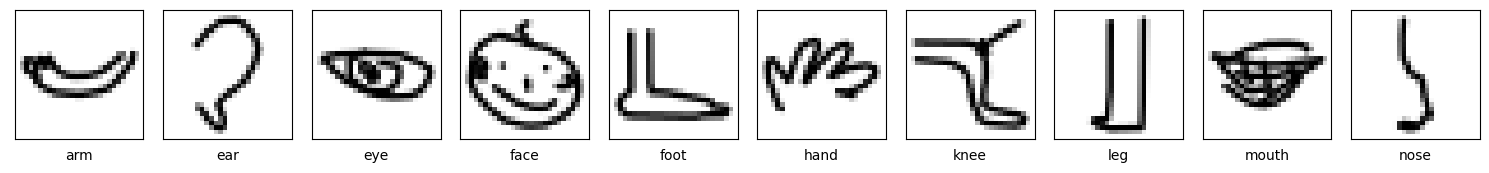

In [14]:
#Plot one of each body part

fig, ax = plt.subplots(1, 10, figsize = (15,15))

for i in range(10):

    part_index = indices[i]
    ax[i].imshow(X_train[part_index], cmap = plt.cm.binary)
    type = y_train[part_index].astype(int)
    ax[i].set_xlabel(body_parts[type])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

fig.tight_layout();

#### Display first 25 images of the training dataset

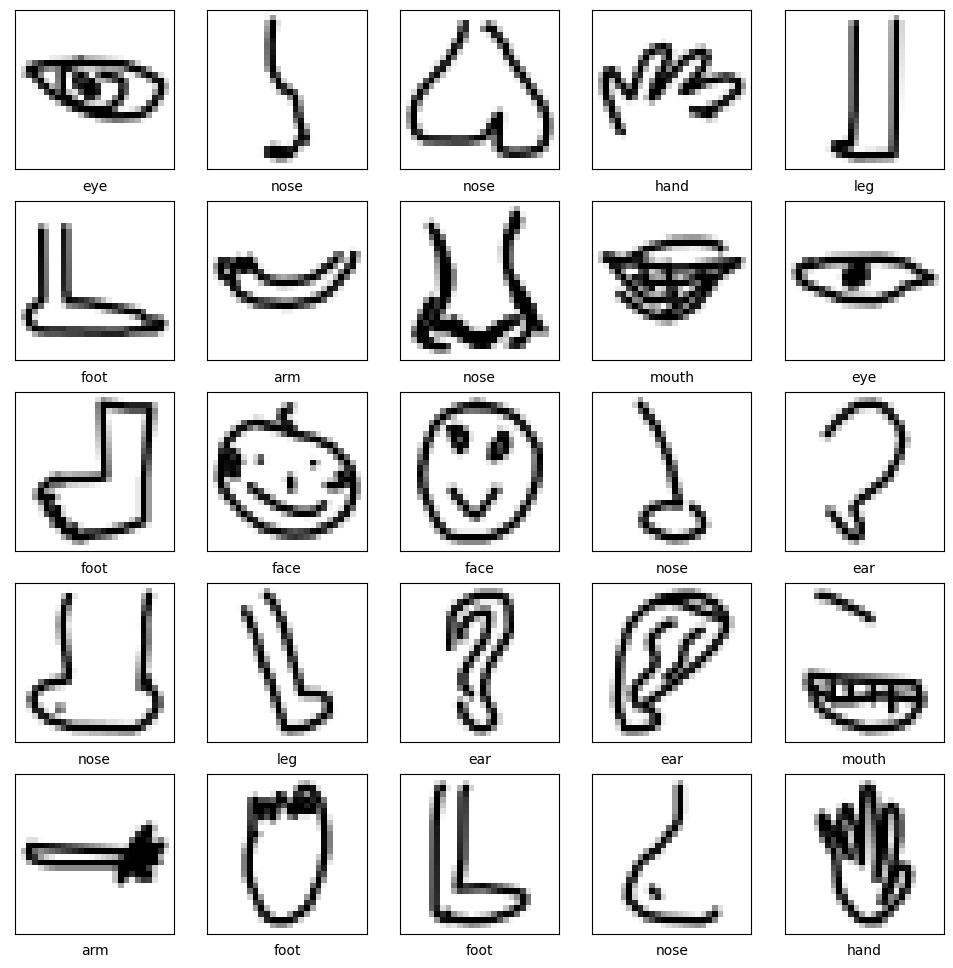

In [15]:
plt.figure(figsize = (12, 12))

for n in range(25):

    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(X_train[n], cmap = plt.cm.binary)

    # chart formatting
    type = y_train[n].astype(int)
    plt.xlabel(body_parts[type])
    plt.xticks([])
    plt.yticks([])

#### Investigate different kernels to an image of type face

Picked the first face in the training dataset

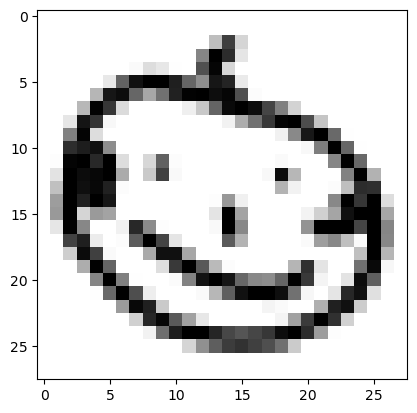

In [16]:
myface = X_train[11]

plt.imshow(myface, cmap = plt.cm.binary);

Define 4 kernels as 3x3 np arrays and add to dict of kernels:
- identity
- edge_detection 
- sharpening
- blurring

In [17]:
k_identity = np.array([[[0],[0],[0]], [[0],[1],[0]], [[0],[0],[0]]])
k_edge= np.array([[[-1],[-1],[-1]], [[-1],[8],[-1]], [[-1],[-1],[-1]]])
k_sharp = np.array([[[0], [-1], [0]], [[-1],[4],[-1]], [[0],[-1],[0]]])
k_blur = np.ones(shape = (3,3,1))/9
kernels = {"identity":k_identity,"edge":k_edge,"sharp":k_sharp,"blur":k_blur}

`run_kernel` function runs over the figure and applies the kernel to every non-edge pixel

In [18]:
def run_kernel(fig,kernel):
    
    #empty array holding the output image
    shape = (fig.shape[0]-2, fig.shape[1]-2, 1)
    out = np.empty(shape = shape)
    for i in range(fig.shape[0]-2):
        for j in range(fig.shape[1]-2):
            out[i][j] = np.sum(np.multiply(kernel,fig[i:i+kernel.shape[0],j:j+kernel.shape[1]]))
                
    return out
    

Check that the kernels are doing what you expect
    
norm = norm(0,1) to scale the image back to between 0 and 1 before plotting

In [19]:
#Import the normiliser for the bitmap
from matplotlib.colors import Normalize as norm

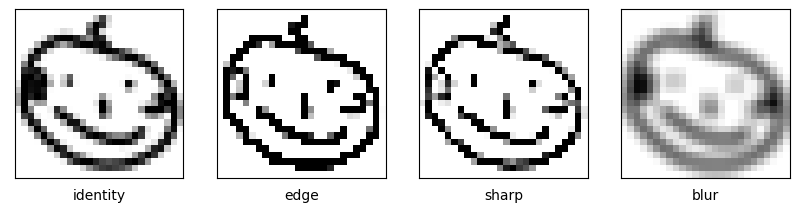

In [20]:
plt.figure(figsize=(10,10))
#Loop over kernel
for i,kernel in enumerate(kernels):
    plt.subplot(1,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #return transformed image and plot it
    plt.imshow(run_kernel(myface,kernels[kernel]), cmap=plt.cm.binary,norm=norm(0,1))  
    plt.xlabel(kernel)
plt.show()



## Image classification using a CNN
---

### Construct CNN using Keras functional API

- Input matches shape of images (28, 28, 1)
- Convolutional layer 32 filters, kernel size 3x3
- Pooling layer 2x2
- Another conv. layer with only 16 filters this time 3x3
- Another pooling layer 2x2
- Flatten into 10 output nodes (# of body parts)

In [21]:
myface.shape

(28, 28, 1)

In [22]:
#CNN structure

visible = Input(shape = (28,28,1))
conv1 = Conv2D(32, kernel_size = 3, activation = 'relu')(visible)
pool1 = MaxPooling2D(pool_size = 2)(conv1)
conv2 = Conv2D(16, kernel_size = 3, activation = 'relu')(pool1)
pool2 = MaxPooling2D(pool_size = 2)(conv2)
flat = Flatten()(pool2)
output = Dense(10, activation = 'sigmoid')(flat)

model = Model(inputs = visible, outputs = output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                4010  

### Compile and train the CNN image classifier 


In [23]:
y_test[:10]

array([7., 1., 9., 8., 4., 4., 8., 0., 5., 5.])

In [24]:
#SparseCat... loss method as integer targets

model.compile(optimizer = 'adam',
              loss = 'SparseCategoricalCrossentropy',
              metrics = ['accuracy'])

In [25]:
#Fit the model

history_model = model.fit(x = X_train, y = y_train, epochs = 20, batch_size = 32, validation_split = 0.2, shuffle = True)

Epoch 1/20
4000/4000 [==============================] - 64s 15ms/step - loss: 0.7627 - accuracy: 0.7634 - val_loss: 0.6490 - val_accuracy: 0.7977
Epoch 2/20
4000/4000 [==============================] - 56s 14ms/step - loss: 0.5964 - accuracy: 0.8154 - val_loss: 0.5883 - val_accuracy: 0.8180
Epoch 3/20
4000/4000 [==============================] - 53s 13ms/step - loss: 0.5542 - accuracy: 0.8266 - val_loss: 0.5607 - val_accuracy: 0.8235
Epoch 4/20
4000/4000 [==============================] - 45s 11ms/step - loss: 0.5292 - accuracy: 0.8345 - val_loss: 0.5487 - val_accuracy: 0.8285
Epoch 5/20
4000/4000 [==============================] - 46s 12ms/step - loss: 0.5125 - accuracy: 0.8386 - val_loss: 0.5321 - val_accuracy: 0.8334
Epoch 6/20
4000/4000 [==============================] - 43s 11ms/step - loss: 0.4999 - accuracy: 0.8424 - val_loss: 0.5271 - val_accuracy: 0.8355
Epoch 7/20
4000/4000 [==============================] - 40s 10ms/step - loss: 0.4911 - accuracy: 0.8452 - val_loss: 0.5191 -

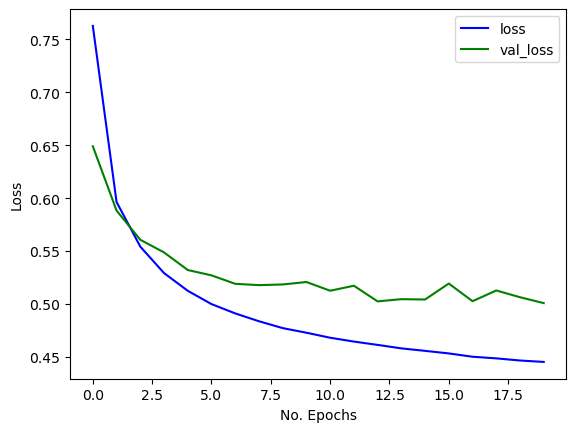

In [26]:
#Plot loss and validation loss

plt.plot(history_model.history['loss'], label = 'loss', color = 'blue')
plt.plot(history_model.history['val_loss'], label = 'val_loss', color = 'green')

plt.legend()
plt.xlabel('No. Epochs')
plt.ylabel('Loss');

### Evaluate the classification performance on the testing dataset

In [27]:
print ('Train accuracy {:.1f}%'.format(model.evaluate(X_train, y_train)[1]*100))
print ('Test accuracy {:.1f}%'.format(model.evaluate(X_test, y_test)[1]*100))

5000/5000 [==============================] - 21s 4ms/step - loss: 0.4439 - accuracy: 0.8586
Train accuracy 85.9%
1250/1250 [==============================] - 6s 4ms/step - loss: 0.5061 - accuracy: 0.8409
Test accuracy 84.1%


Seems relatively good

#### Make predictions and compare

In [28]:
#Predict which body parts
predictions = model.predict(X_test)

#Get the largest probability, i.e. which body part the model thinks the image is
y_pred = np.argmax(predictions, axis = 1)

In [29]:
#Find where the model is guessing incorrectly

comparison = (y_pred == y_test)
wrong_predictions = np.where(comparison == False)[0]
wrong_predictions

array([    0,    12,    26, ..., 39982, 39984, 39999], dtype=int64)

In [30]:
print (body_parts)

['arm', 'ear', 'eye', 'face', 'foot', 'hand', 'knee', 'leg', 'mouth', 'nose']


0
9.0


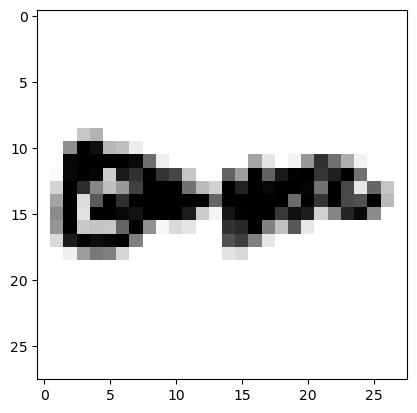

In [31]:
#Just double check some of the incorrect predictions

print (predictions[12].argmax())
print(y_test[12])
plt.imshow(X_test[12], cmap = plt.cm.binary);

#### Plot some of the incorrect predictions

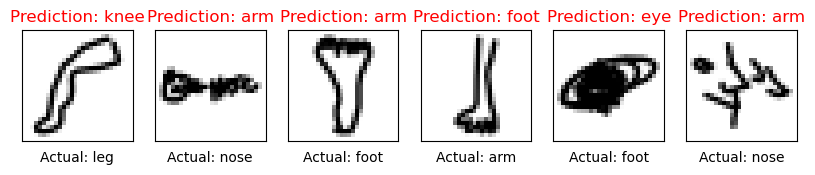

In [32]:
plt.figure(figsize = (10, 10))

for n in range(6):

    ax = plt.subplot(1, 6, n + 1)
    bad_prediction_index = wrong_predictions[n]
    plt.imshow(X_test[bad_prediction_index], cmap = plt.cm.binary)

    # chart formatting
    type_actual = y_test[bad_prediction_index].astype(int)
    type_predicted = y_pred[bad_prediction_index].astype(int)
    
    plt.xlabel('Actual: {}'.format(body_parts[type_actual]))
    plt.title('Prediction: {}'.format(body_parts[type_predicted]), color = 'r')
    plt.xticks([])
    plt.yticks([])

#### Plot the confusion matrix

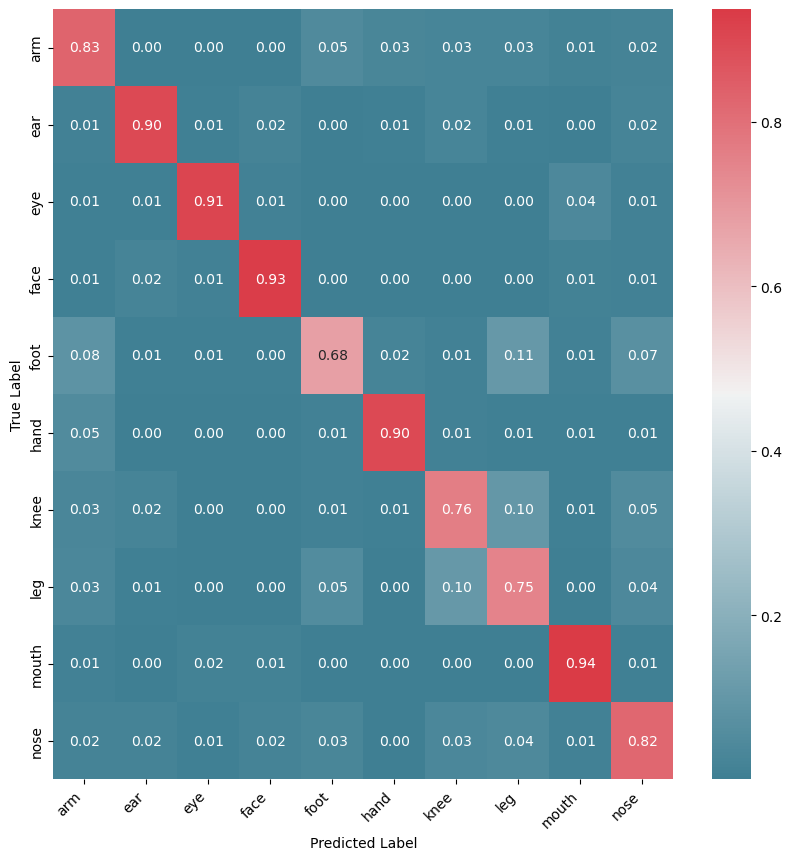

In [33]:
cm = confusion_matrix(y_test, y_pred, normalize = 'true')

# Use the following courmap in as the cmap parameter of sns.heatmap:
colormap = sns.diverging_palette(220, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(10, 10))
# Generate Heat Map, allow annotations and place floats in map
sns.heatmap(cm , cmap=colormap, annot=True, fmt=".2f")
ax.set_xticklabels(
    body_parts,
    rotation=45,
    horizontalalignment='right'
);
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_yticklabels(body_parts);
plt.show()

Makes sense that the model has a harder time distinguishing between a knee, leg, and foot. Arm confused with foot. Good at predicting faces, eyes, and mouths

Run the first layer kernels over `myface`. Can see several copies of the image, all with varying transformations

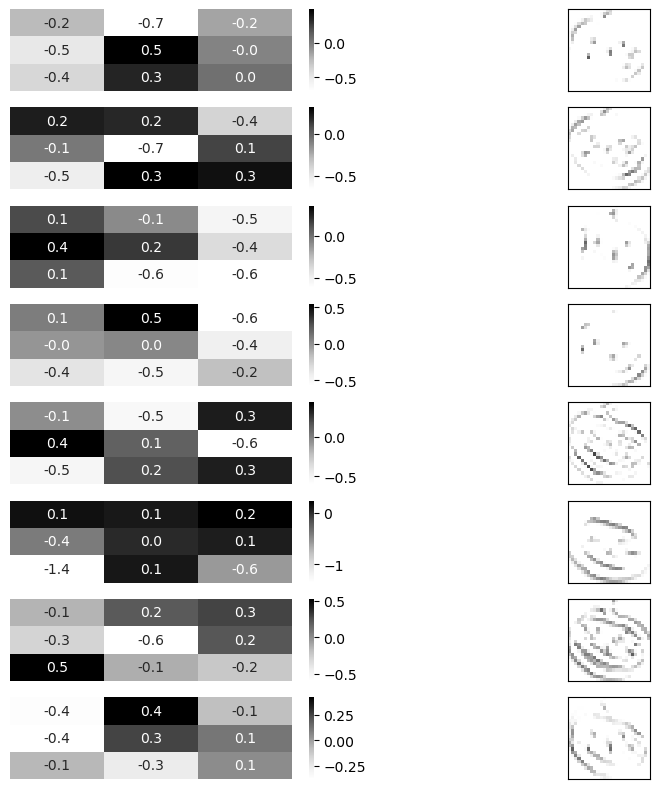

In [34]:
plt.figure(figsize=(10,10))
for i in range(8):
    plt.subplot(8,2,2*(i)+1)

    sns.heatmap(model.layers[1].get_weights()[0][:,:,:,i][:,:,0], cmap='Greys',annot=True,fmt=".1f")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.subplot(8,2,2*i+2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(run_kernel(myface,model.layers[1].get_weights()[0][:,:,:,i]),cmap=plt.cm.binary,norm=norm(0,1))
plt.show()


### Predict a couple of sketches made with paint

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [36]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]

    grey = np.zeros(shape = (28,28,1))
    grey[:, :, 0] = 0.2989 * r + 0.5870 * g + 0.1140 * b
    grey[:, :, 0] = grey[:, :, 0] < 0.5

    return grey

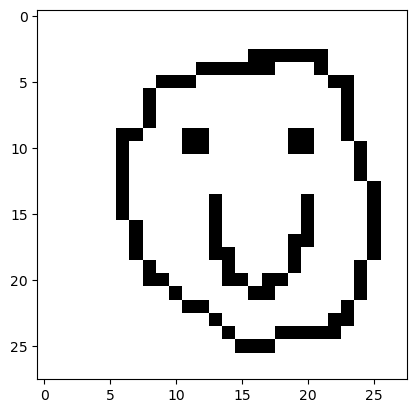

In [37]:
img_denis = mpimg.imread('denis_face.png')     
grey_denis = rgb2gray(img_denis)    

plt.imshow(grey_denis, cmap=plt.cm.binary)
plt.show()

In [38]:
body_parts[model.predict(np.array([grey_denis])).argmax()]

'face'

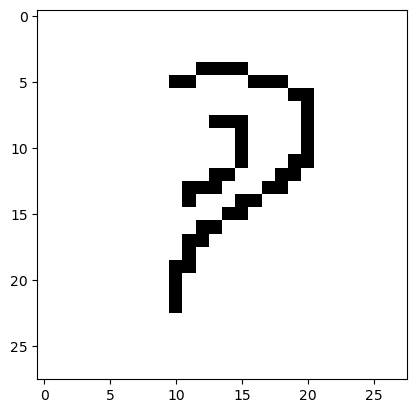

In [39]:
img_cristina = mpimg.imread('cristina_ear.png')
grey_cristina = rgb2gray(img_cristina)    

plt.imshow(grey_cristina, cmap=plt.cm.binary)
plt.show()

In [40]:
body_parts[model.predict(np.array([grey_cristina])).argmax()]

'ear'

## Auto-encoders
---


#### Construct encoder 

- `Keras` functional API
- Input shape matches image size (28, 28, 1)
- Added some convolutional and pooling layers all with padding 'same' 
- Create information `bottleneck` which and final layer flattened into latent vector with sigmoid activation function

In [6]:
input_img = Input(shape = (28,28,1), name = 'input')
enc_conv1 = Conv2D(16, kernel_size = 3, activation = 'relu', padding = 'same')(input_img)
enc_pool1 = MaxPooling2D(pool_size = 2, padding = 'same')(enc_conv1)
enc_conv2 = Conv2D(8, kernel_size = 3, activation = 'relu', padding = 'same')(enc_pool1)
enc_pool2 = MaxPooling2D(pool_size = 2, padding = 'same')(enc_conv2)
enc_conv3 = Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same')(enc_pool2)
enc_conv4 = Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same')(enc_conv3)
enc_conv5 = Conv2D(1, kernel_size = 3, activation = 'sigmoid', padding = 'same')(enc_conv4)
enc_output = Flatten()(enc_conv5)

encoder = Model(inputs = input_img, outputs = enc_output, name = 'encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 4)           292       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 2)           74  

In [7]:
#Doesn't really work on my laptop...

#plot_model(encoder, show_shapes = True)

####  Construct the decoder

- Reverse encoder 
- Essentially chose the same structure as the encoder but upsampling rather than pooling
- make sure input/ outputs appropriate sizes

In [8]:
encoding_shape = encoder.layers[-2].output_shape[1:]  # Get the shape right before final output, which can also just be read off the summary
encoding_shape

(7, 7, 1)

In [9]:
dec_input = Input(shape = (np.prod(encoding_shape), ))
dec_rshp = Reshape(encoding_shape)(dec_input)
dec_conv1 = Conv2D(16, kernel_size = 3, activation = 'relu', padding = 'same')(dec_rshp)
dec_up1 = UpSampling2D(size = 2)(dec_conv1)
dec_conv2 = Conv2D(8, kernel_size = 3, activation = 'relu', padding = 'same')(dec_up1)
dec_up2 = UpSampling2D(size = 2)(dec_conv2)
dec_conv3 = Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same')(dec_up2)
dec_conv4 = Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same')(dec_conv3)
dec_output = Conv2D(1, kernel_size = 3, activation = 'sigmoid', padding = 'same')(dec_conv4)


decoder = Model(inputs = dec_input, outputs = dec_output, name = 'decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 49)]              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 1)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 16)          160       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 4)         292 

#### Construct the auto-encoder 


In [10]:
i   = encoder.input
cae = Model(i, decoder(encoder(i)), name='ConvAE')
cae.summary()

Model: "ConvAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 49)                1705      
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         1705      
Total params: 3,410
Trainable params: 3,410
Non-trainable params: 0
_________________________________________________________________


#### Compile and train AE

* binary loss function as images have have values between 0 and 1
* 10 epochs (can't really run for longer) and 20% validation


In [11]:
#binary_crossentropy as the input and output image should have pixel values between 0 and 1

cae.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

history_cae = cae.fit(x = X_train, y = X_train, epochs = 10, validation_split = 0.2, batch_size = 32)

Epoch 1/10
4000/4000 [==============================] - 168s 42ms/step - loss: 0.2091 - accuracy: 0.7616 - val_loss: 0.1774 - val_accuracy: 0.7706
Epoch 2/10
4000/4000 [==============================] - 163s 41ms/step - loss: 0.1718 - accuracy: 0.7744 - val_loss: 0.1656 - val_accuracy: 0.7777
Epoch 3/10
4000/4000 [==============================] - 161s 40ms/step - loss: 0.1617 - accuracy: 0.7791 - val_loss: 0.1580 - val_accuracy: 0.7800
Epoch 4/10
4000/4000 [==============================] - 161s 40ms/step - loss: 0.1570 - accuracy: 0.7804 - val_loss: 0.1551 - val_accuracy: 0.7804
Epoch 5/10
4000/4000 [==============================] - 162s 41ms/step - loss: 0.1546 - accuracy: 0.7809 - val_loss: 0.1534 - val_accuracy: 0.7808
Epoch 6/10
4000/4000 [==============================] - 161s 40ms/step - loss: 0.1533 - accuracy: 0.7811 - val_loss: 0.1526 - val_accuracy: 0.7813
Epoch 7/10
4000/4000 [==============================] - 160s 40ms/step - loss: 0.1525 - accuracy: 0.7813 - val_loss: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4000/4000 [==============================] - 160s 40ms/step - loss: 0.1518 - accuracy: 0.7814 - val_loss: 0.1522 - val_accuracy: 0.7811
Epoch 9/10
4000/4000 [==============================] - 161s 40ms/step - loss: 0.1512 - accuracy: 0.7815 - val_loss: 0.1506 - val_accuracy: 0.7814
Epoch 10/10
4000/4000 [==============================] - 161s 40ms/step - loss: 0.1508 - accuracy: 0.7815 - val_loss: 0.1503 - val_accuracy: 0.7816


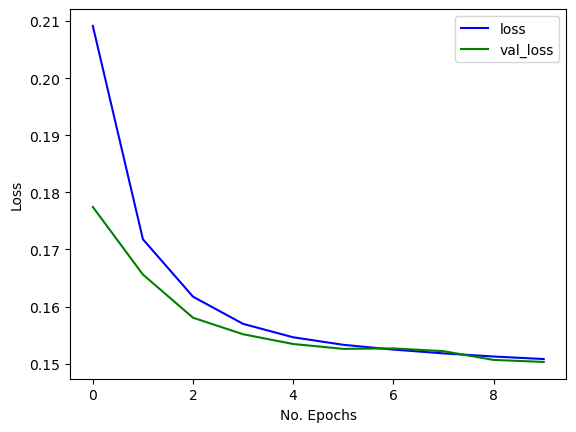

In [12]:
#Plot loss and validation loss

plt.plot(history_cae.history['loss'], label = 'loss', color = 'blue')
plt.plot(history_cae.history['val_loss'], label = 'val_loss', color = 'green')

plt.legend()
plt.xlabel('No. Epochs')
plt.ylabel('Loss');

In [13]:
predicted_test = cae.predict(X_test) 

#### Show some of the encoded images 

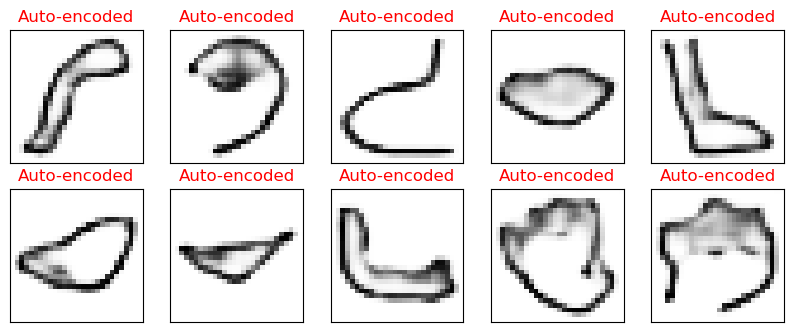

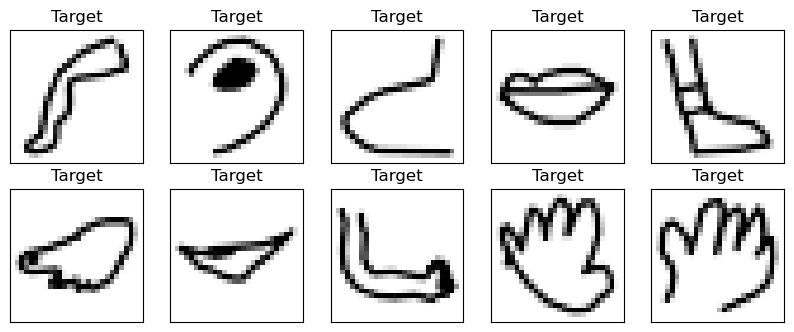

In [14]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(predicted_test[i], cmap='Greys')
    plt.title('Auto-encoded', color = 'red')
plt.show()

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap='Greys')
    plt.title('Target')
plt.show()

Thumbs up looks good

#### Plot images in the latent space


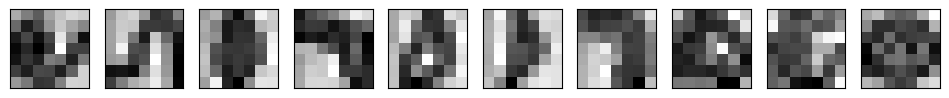

In [15]:
encoded_images = encoder.predict(X_test)

n = 10
plt.figure(figsize=(12, 12))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_images[i].reshape((7, 7)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Anomaly detection 
---

Do some anomaly detection with the olivetti faces

In [16]:
faces_64x64 = np.load('/kaggle/input/olivettifaces/olivetti_faces.npy', allow_pickle = True)
np.random.shuffle(faces_64x64)

In [17]:
print (faces_64x64.shape)

(400, 64, 64)


In [18]:
from PIL import Image

- Have to rescale the images as theyre originally 64x64 but need 28x28

In [19]:
Rescaled_faces = []

for face in faces_64x64:
    img_array = face
    img_pil = Image.fromarray(img_array)
    img_28x28 = np.array(img_pil.resize((28, 28), Image.ANTIALIAS))
    Rescaled_faces.append(img_28x28)

/tmp/ipykernel_33/1226408296.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_28x28 = np.array(img_pil.resize((28, 28), Image.ANTIALIAS))


In [20]:
faces_28x28 = np.array(Rescaled_faces)
faces_28x28[faces_28x28 < 0] = 0

In [21]:
faces_28x28 = faces_28x28.reshape(400,28,28,1)

#### Show some of the faces and the autoencoder results

No. of images: 400
Shape: (28, 28, 1)
Pixel intensity range: [0.0, 0.9763513207435608]


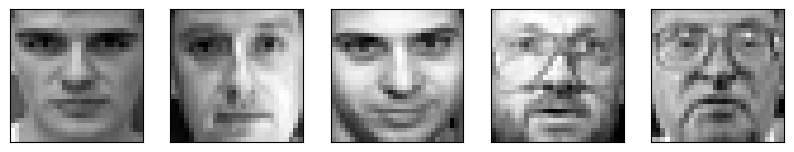

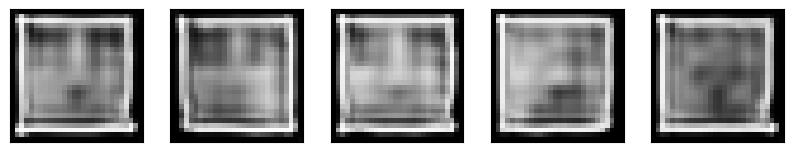

In [62]:
print("No. of images:",faces_28x28.shape[0])
print("Shape:",faces_28x28.shape[1:])
print("Pixel intensity range: [{}, {}]".format(faces_28x28.min(), faces_28x28.max()))
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(faces_28x28[i])
plt.show()

predicted_faces = cae.predict(faces_28x28)

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(predicted_faces[i])
plt.show()


  
* Faces have same shape and pixel intensity range as the quickdraw images so they are valid inputs to the auto-encoder
* AE faces not similar at all as of course AE trained on quickdraw set not the faces
* Theyre 'anomalies' clearly

#### Perform anomaly detection
Mix the faces into the quickdraw set

In [23]:
# Combined MNIST images and "outliers" in a mixed dataset
mixed = np.vstack((X_test, faces_28x28))

# Shuffle the mixed dataset so the "outliers" are randomly distributed
indices = np.random.permutation(mixed.shape[0])
mixed   = mixed[indices]

In [24]:
predicted_mixed = cae.predict(mixed)

In [29]:
eps = np.finfo(float).eps
print(np.clip(predicted_mixed, eps, 1. - eps).min())
print(predicted_mixed.min())

2.220446e-16
2.7464392e-34


The `binary_crossentropy` method provided below computes **pixel-wise BCE** for two (arrays of) images: the input and the output image.

In [30]:
def binary_crossentropy (img_in, img_out):
    assert img_in.shape == img_out.shape
    eps = np.finfo(float).eps
    img_out = np.clip(img_out, eps, 1. - eps)
    return - (img_in * np.log(img_out) + (1 - img_in) * np.log(1 - img_out))

---
Difference calculates a mean value per pic of the binary cross entropy

In [31]:
def difference(img_in, img_out):
    return binary_crossentropy(img_in, img_out).mean(axis = (1, 2, 3))

In [37]:
score = difference(mixed, predicted_mixed)

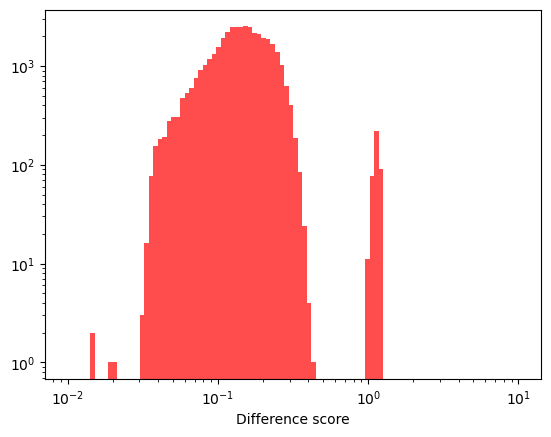

In [56]:
#Can plot histogram of course some outliers (the faces)

bins = np.logspace(-2, 1, 100+1)
plt.hist(score, alpha=0.7, color = 'red', bins = bins);
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Difference score');

Double check which images are the outliers and have been autoencoded badly (the faces)

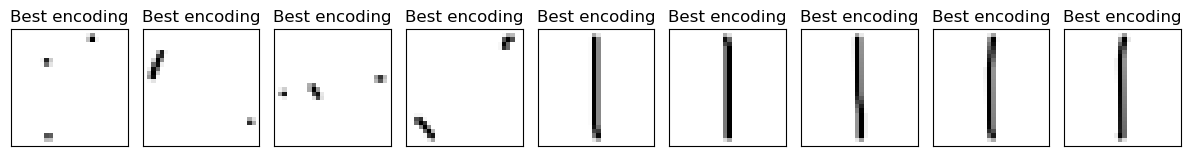

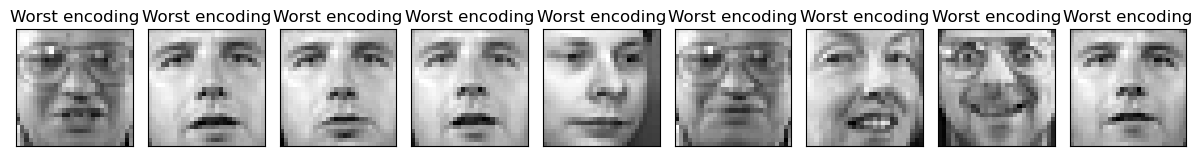

In [87]:
score_sorted = np.argsort(score)

# print 9 best and worst encoded images

n = 9  # How many digits we will display
plt.figure(figsize = (12, 12))
for i in range(n):
    
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(mixed[score_sorted[i]].reshape(28, 28), cmap = plt.cm.binary)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Best encoding")
    
plt.tight_layout()
plt.show()

plt.figure(figsize = (12, 12))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(mixed[score_sorted[-(i+1)]].reshape(28, 28), cmap = plt.cm.binary)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Worst encoding")
    
plt.tight_layout()
plt.show();
